# Short-term electricity load forecasting 
### (Panama case study)

## User Input: Introduce your directories

In [1]:
# Base directory
base_dir = r'c:\Users\wiki\Desktop\summer internship'

# Directory to import cleaned and transformed dataframes for modelling
import_dir = base_dir

# Directory to save models and optimization studies
models_dir = base_dir + r'\models'

#### Context
These case study are framed on predicting the short-term electricity, this forecasting problem is known in the research field as short-term load forecasting (STLF). These datasets address the STLF problem for the Panama power system, in which the forecasting horizon is one week, with hourly steps, which is a total of 168 hours. These datasets are useful to train and test forecasting models and compare their results with the grid operator official forecast ([take a look at real-time electricity load](https://sitr.cnd.com.pa/m/pub/sin.html)). The datasets include historical load, a vast set of weather variables, holidays, and historical load weekly forecast features.

#### Objectives
The main objectives around these datasets are:
1. Evaluate the grid operator official forecasts (weekly pre-dispatch forecast) against the real load, on weekly basis.
2. Develop, train and test forecasting models to improve the operator official weekly forecasts (168 hours), in different scenarios.

#### Considerations to compare results
The following considerations should be kept to compare forecasting results with the weekly pre-dispatch forecast:

1. Saturday is the first day of each weekly forecast; for instance, Friday is the last day.
2. The first full-week starting on Saturday should be considered as the first week of the year, to number the weeks.
3. A 72 hours gap of unseen records should be considered before the first day to forecast. In other words, next week forecast should be done with records until each Tuesday last hour.
4. Make sure to train and test keeping the chronological order of records.

## Install packages

In [27]:
pip install xlrd==1.2.0

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install optuna==2.3.0

Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install plotly==4.14.1

Note: you may need to restart the kernel to use updated packages.


## Import packages

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from IPython import display
import plotly as plotly
%matplotlib inline

import calendar
import datetime as dt
from datetime import timedelta, date
from pprint import pprint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import joblib
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from scipy.stats import randint as sp_randint
from time import time
import pickle

import warnings
warnings.filterwarnings('ignore')

# set random_state
random_state = 123

c:\Users\wiki\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Animation of the 14 suggested training-testing pairs along the horizon 

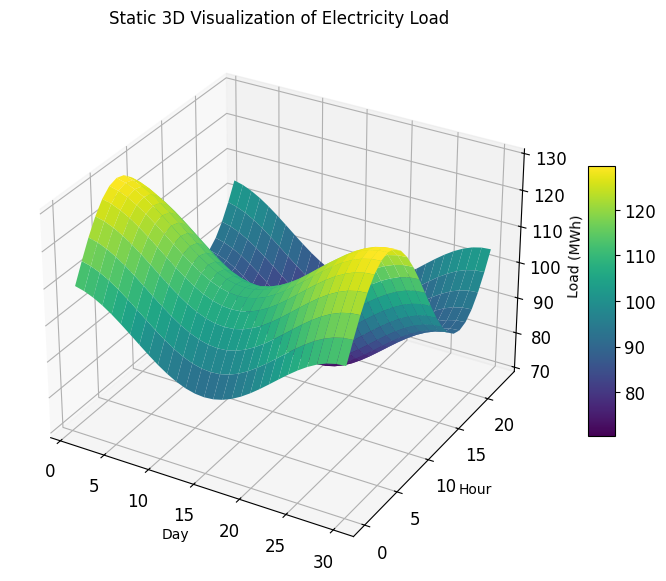

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data: simulate load over days and hours
days = np.arange(1, 31)          # 30 days
hours = np.arange(0, 24)         # 24 hours
days_grid, hours_grid = np.meshgrid(days, hours)

# Simulate load as some function of day and hour (just for demo)
load = 100 + 20 * np.sin(2 * np.pi * hours_grid / 24) + 10 * np.cos(2 * np.pi * days_grid / 30)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(days_grid, hours_grid, load, cmap='viridis')

ax.set_xlabel('Day')
ax.set_ylabel('Hour')
ax.set_zlabel('Load (MWh)')
ax.set_title('Static 3D Visualization of Electricity Load')

fig.colorbar(surf, shrink=0.5, aspect=10)

# Save as PNG
plt.savefig('static_3d_load_plot.png', bbox_inches='tight')
plt.show()



The continious dataset was split into train and test datasets, keeping the cronological order of the records, this is, keeping records sorted by 'datetime', leaving always the **last week for testing the model and the rest, older data for training it.** <br>

Based on this logic, there will be 14 pairs of train/test datasets. 12 pairs with the testing week on each month of the last year of records, before the quarentine started, and 2 more testing weeks after the quarentine started. As a fact, the lockdown in Panama started on Wednesday March 25th of 2020 (week 12 - 2020). <br>

The following table shows more information about the train/test splits: <br>

| Testing week number| Testing week name | Datetime split |
| -: | -: | -: |
|                   1 | Week 15, Apr 2019 | 2019-04-13 01:00:00 |
|                   2 | Week 21, May 2019 | 2019-05-25 01:00:00 |
|                   3 | Week 24, Jun 2019 | 2019-06-15 01:00:00 |
|                   4 | Week 29, Jul 2019 | 2019-07-20 01:00:00 |
|                   5 | Week 33, Aug 2019 | 2019-08-17 01:00:00 |
|                   6 | Week 37, Sep 2019 | 2019-09-14 01:00:00 |
|                   7 | Week 41, Oct 2019 | 2019-10-12 01:00:00 |
|                   8 | Week 44, Nov 2019 | 2019-11-02 01:00:00 |
|                   9 | Week 51, Dec 2019 | 2019-12-21 01:00:00 |
|                  10 | Week 01, Jan 2020 | 2020-01-04 01:00:00 |
|                  11 | Week 06, Feb 2020 | 2020-02-08 01:00:00 |
|                  12 | Week 10, Mar 2020 | 2020-03-07 01:00:00 |
|                  13 | Week 20, May 2020 | 2020-05-16 01:00:00 |
|                  14 | Week 24, Jun 2020 | 2020-06-13 01:00:00 |

# 1.0 Import datasets

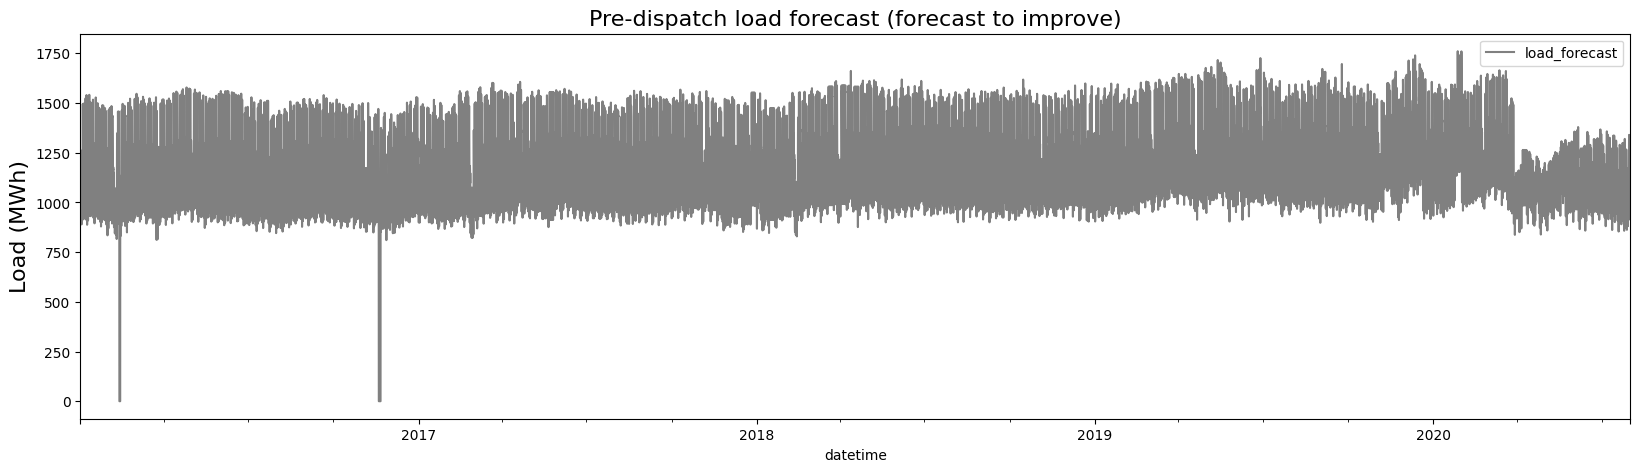

In [4]:
# set the working directory
os.chdir(import_dir)

# csv file with load forecast to improve (weekly pre-dispatch)
filename = 'weekly pre-dispatch forecast.csv'

# Read the file and convert into "pre_disp_df" 
pre_disp_df = pd.read_csv(filename)

# set datetime as index
pre_disp_df.set_index('datetime', inplace=True)

# converting the index as date
pre_disp_df.index = pd.to_datetime(pre_disp_df.index)

# plot weekly pre-dispatch forecast (forecast to improve)
pre_disp_df.plot(figsize=(20,5), color='grey')
plt.title('Pre-dispatch load forecast (forecast to improve)', fontsize=16)
plt.ylabel('Load (MWh)', fontsize=16);
plt.savefig("pre_dispatch_plot.png", bbox_inches='tight')


In [5]:
# set the working directory
os.chdir(import_dir)

# Import a dictionary with all the training dataframes
# Use parameter sheet_name=None, from pd.read_excel
# to return a dictionary of Dataframes, with the sheet_names as dictionary keys.
train_dict = pd.read_excel(open('train_dataframes.xlsx', 'rb'), sheet_name = None, index_col=0)

# Import a dictionary with all the testing dataframes
test_dict = pd.read_excel(open('test_dataframes.xlsx', 'rb'), sheet_name = None, index_col=0)

In [6]:
# Get the keys from 'test_dict' dictionary
# keys are the same for both 'test_dict' and 'train_dict'
keys = list(test_dict.keys())

# Show keys
keys

['Week 15, Apr 2019',
 'Week 21, May 2019',
 'Week 24, Jun 2019',
 'Week 29, Jul 2019',
 'Week 33, Aug 2019',
 'Week 37, Sep 2019',
 'Week 41, Oct 2019',
 'Week 44, Nov 2019',
 'Week 51, Dec 2019',
 'Week 01, Jan 2020',
 'Week 06, Feb 2020',
 'Week 10, Mar 2020',
 'Week 20, May 2020',
 'Week 24, Jun 2020']

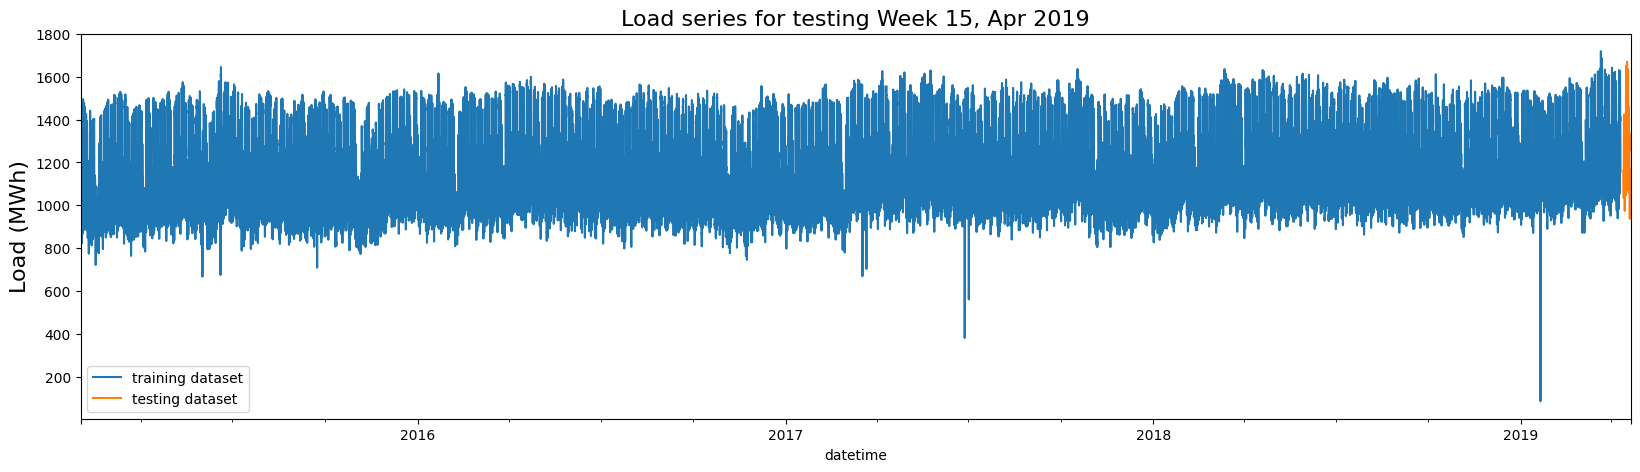

In [7]:
# Plot the electricity load, just for the first training/testing pair 
# notice the small gap between the two series, it's the 72 hours gap
train_dict[keys[0]]['DEMAND'].plot(figsize=(20,5), label='training dataset')
test_dict[keys[0]]['DEMAND'].plot(figsize=(20,5), label='testing dataset')
plt.ylabel('Load (MWh)', fontsize=16)
plt.title('Load series for testing ' + keys[0],fontsize=16)
plt.legend();
plt.savefig("weekly_split_example.png", bbox_inches='tight')


# 2.0 Define functions

In [8]:
################################################################################
# ------------------------- MAPE evaluation functions --------------------------
################################################################################

# Define a function to calculate WEEKLY Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

# Define a function to calculate HOURLY Mean Absolute Percentage Error (MAPE)
def H_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    H_MAPE = (np.abs((y_true - y_pred) / y_true) * 100)
    rounded_H_MAPE = [round(num, 1) for num in H_MAPE]
    return rounded_H_MAPE

In [9]:
################################################################################
# ------------------ Time-based train and test splitting -----------------------
################################################################################
# Reference:
# https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period'+'-gap)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period'+'-gap)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 

In [10]:
################################################################################
# ------------------- Plotting test and demand forecast  -----------------------
################################################################################

def plot_test_forecast(y_test, y_pred_test, y_pre_disp):
  # Calculate values to plot
  delta_demand = y_test - y_pred_test
  H_MAPE = H_mean_absolute_percentage_error(y_test, y_pred_test)

  import matplotlib.pyplot
  from matplotlib.ticker import MaxNLocator
  import matplotlib.ticker
  fig, (ax, bx) = plt.subplots(1,2, figsize=(20, 5))
  matplotlib.rc('xtick', labelsize=12) 
  matplotlib.rc('ytick', labelsize=12) 

  # First plot
  ax.plot(np.arange(1, 169, 1), y_test, c= 'green', label = 'Real Demand')
  ax.plot(np.arange(1, 169, 1), y_pred_test, c= 'red', label = 'Demand Forecast')
  ax.plot(np.arange(1, 169, 1), y_pre_disp, c= 'gray', linestyle='--', label = 'Pre-dispatch Forecast')
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.set_xlabel('Hours of the week', fontsize = 12)
  ax.set_ylabel('MWh', rotation=0, fontsize = 12, labelpad=20)
  ax.set_title('Real demand vs Forecasts')
    
  # Second plot
  bx.bar(np.arange(1, 169, 1), delta_demand, width=1.0, color = 'grey', label = 'Error')
  bx.xaxis.set_major_locator(MaxNLocator(integer=True))
  bx.set_xlabel('Hours of the week', fontsize = 12)
  bx.set_ylabel('MWh', rotation=0, fontsize = 12, labelpad=5)
  bx.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
  bx2 = bx.twinx()  # instantiate a second axes that shares the same x-axis
  legend = ax.legend(loc='lower left', fontsize = 12)
  bx.set_title('Forecast errors and MAPE')

  # Calculate weekly MAPE to improve
  MAPE2improve = mean_absolute_percentage_error(y_test, y_pre_disp)

  color = 'tab:blue'
  bx2.set_ylabel('MAPE', color=color, labelpad=20, rotation=0, fontsize = 12)
  bx2.plot(np.arange(1, 169, 1), H_MAPE, color=color, label = 'Absolute Error (%)')
  bx2.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0))
  bx2.tick_params(axis='y', labelcolor=color)
  bx2.set_ylim(bottom=0)
  plt.axhline(y=MAPE2improve, color='k', linestyle='--', label = str('Error cap (' + str(MAPE2improve)+'%)'))
  legend = bx.legend(loc='upper left', fontsize = 12)
  legend = bx2.legend(loc='upper right', fontsize = 12)

  fig.tight_layout()
  plt.show()

In [40]:
!pip install xgboost

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def model_hyperparameter_search(trial):
    # Define hyperparameter space
    space = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }

    # Create the XGBRegressor with the trial parameters
    reg = XGBRegressor(**space)

    # Evaluate using cross-validation; remember X, y, index_output must be defined in the outer scope
    rmse_cv_score = round(cross_val_score(
        reg, X, y,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        cv=index_output
    ).mean(), 3)

    return rmse_cv_score


In [12]:
################################################################################
# ---------------------- Function to train a model --------------------------
################################################################################
# This function train a model
# This function uses: X_Train, y_train
# This fuction returns a trained and fitted model and the optimization study
# The estimator or pipeline is fixed and defined inside

def train_model(data_for_modeling):
    # -------------- Train the model using only the holidays data ---------------
    # Create a study object setting the sampling and direction 
    # of the optimization process (maximize -RMSE with Bayesian GMM)
    
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=random_state))
    # Define the function to optimize, number of trials, execution time and processors to use
    study.optimize(model_hyperparameter_search, n_trials=10, timeout=None, n_jobs=-1)
    # Fit the estimator using the best hyperparameters
    reg = XGBRegressor(**study.best_trial.params)

    
    # ------------- Return trained model using only the holidays data -------------
    X_train = data_for_modeling.set_index(['record_date']).drop(columns=['DEMAND'])
    y_train = data_for_modeling['DEMAND']
    return reg.fit(X_train, y_train), study

# 3.0 Optimize models for each testing week

Notice keys list is contrained to its first element **keys[:1]** to run a fast demo <br>
select the whole list 'keys' to train 14 models

In [ ]:
%%time
################################################################################
# -------------- Loop to optimize models for each testing week -----------------
################################################################################

for key in keys[:1]: 
   
    train_df = train_dict[key]

  
    X_train = train_dict[key].drop(columns=['DEMAND'])
    X_test = test_dict[key].drop(columns=['DEMAND'])
    y_train = train_dict[key]['DEMAND']
    y_test  = test_dict[key]['DEMAND']
    
    mean_load = train_df['DEMAND'].mean()
    std_load = train_df['DEMAND'].std()
    upper_bound = mean_load + 3 * std_load
    lower_bound = mean_load - 3 * std_load


    train_df['DEMAND'] = train_df['DEMAND'].mask(
        (train_df['DEMAND'] > upper_bound) | (train_df['DEMAND'] < lower_bound)
    )
   
    train_df['DEMAND'] = train_df['DEMAND'].interpolate(method='linear')

    
    mean_load_test = test_dict[key]['DEMAND'].mean()
    std_load_test = test_dict[key]['DEMAND'].std()
    upper_bound_test = mean_load_test + 3 * std_load_test
    lower_bound_test = mean_load_test - 3 * std_load_test

    test_df = test_dict[key].copy()
    test_df['DEMAND'] = test_df['DEMAND'].mask(
        (test_df['DEMAND'] > upper_bound_test) | (test_df['DEMAND'] < lower_bound_test)
    )
    test_df['DEMAND'] = test_df['DEMAND'].interpolate(method='linear')


    X_train = train_df.drop(columns=['DEMAND'])
    y_train = train_df['DEMAND']
    X_test = test_df.drop(columns=['DEMAND'])
    y_test = test_df['DEMAND']
  
    train_df = pd.DataFrame(data=train_df.values, index=pd.Series(train_df.index).dt.round("H"), columns=train_df.columns)
    X_train = pd.DataFrame(data=X_train.values, index=pd.Series(X_train.index).dt.round("H"), columns=X_train.columns)
    X_test = pd.DataFrame(data=X_test.values, index=pd.Series(X_test.index).dt.round("H"), columns=X_test.columns)
    y_train = pd.Series(data=y_train.values, index=pd.Series(y_train.index).dt.round("H"), name=y_train.name)
    y_test = pd.Series(data=y_test.values, index=pd.Series(y_test.index).dt.round("H"), name=y_test.name)
    
    
    y_pre_disp = pd.merge(y_test, pre_disp_df['load_forecast'], how='inner', left_index=True, right_index=True)['load_forecast']
    

    weeks_to_val = 64
    hours_to_val = (weeks_to_val*168 + 168)
    train_val_split  = train_df.index[(-hours_to_val)].strftime('%Y-%m-%d %H:%M:%S')
    

    tscv = TimeBasedCV(train_period = 25032, 
                       test_period = 168,     
                       freq = 'hours')
    
   
    data_for_modeling = train_df.reset_index(level=0)
    data_for_modeling.rename(columns={'datetime' : 'record_date'}, inplace=True)
    data_for_modeling['record_date'] =  pd.to_datetime(data_for_modeling['record_date'], format='%Y/%m/%d %H:%M:%S')  
    
    X = data_for_modeling.drop(columns=['DEMAND', 'record_date'], axis=1)
    y = data_for_modeling['DEMAND']
    index_output = tscv.split(data_for_modeling, 
                          validation_split_date=dt.strptime(train_val_split, '%Y-%m-%d %H:%M:%S').date(),
                          gap = 72) 
    

    generic_model, generic_model_study = train_model(data_for_modeling)
    
    os.chdir(models_dir)

    filename = 'xgb_study_'+ str(key) + '.pkl'
    joblib.dump(generic_model_study, filename)
    del filename
    filename = 'xgb_'+ str(key) + '.sav'
    pickle.dump(generic_model, open(filename, 'wb'))
    del filename

Train period: 2015-03-04 - 2018-01-07 , Test period 2018-01-10 - 2018-01-17 # train records 24960 , # test records 168
Train period: 2015-03-11 - 2018-01-14 , Test period 2018-01-17 - 2018-01-24 # train records 24960 , # test records 168
Train period: 2015-03-18 - 2018-01-21 , Test period 2018-01-24 - 2018-01-31 # train records 24960 , # test records 168
Train period: 2015-03-25 - 2018-01-28 , Test period 2018-01-31 - 2018-02-07 # train records 24960 , # test records 168
Train period: 2015-04-01 - 2018-02-04 , Test period 2018-02-07 - 2018-02-14 # train records 24960 , # test records 168
Train period: 2015-04-08 - 2018-02-11 , Test period 2018-02-14 - 2018-02-21 # train records 24960 , # test records 168
Train period: 2015-04-15 - 2018-02-18 , Test period 2018-02-21 - 2018-02-28 # train records 24960 , # test records 168
Train period: 2015-04-22 - 2018-02-25 , Test period 2018-02-28 - 2018-03-07 # train records 24960 , # test records 168
Train period: 2015-04-29 - 2018-03-04 , Test per

[I 2025-08-02 16:30:48,979] A new study created in memory with name: no-name-79cc810d-5dcc-4803-b4cc-7be5e448d5ec


Train period: 2016-05-18 - 2019-03-24 , Test period 2019-03-27 - 2019-04-03 # train records 24960 , # test records 168


[I 2025-08-02 16:45:15,154] Trial 6 finished with value: -48.703 and parameters: {'max_depth': 4, 'n_estimators': 280, 'learning_rate': 0.021535522658336866, 'subsample': 0.6903476117451718, 'colsample_bytree': 0.8063770313103344, 'gamma': 2.415944088991267, 'reg_alpha': 7.878803446479015, 'reg_lambda': 0.003204109773344843}. Best is trial 6 with value: -48.703.
[I 2025-08-02 16:49:34,998] Trial 4 finished with value: -47.77 and parameters: {'max_depth': 6, 'n_estimators': 273, 'learning_rate': 0.03138032574595294, 'subsample': 0.7580698571289313, 'colsample_bytree': 0.7475999297588473, 'gamma': 2.0132228136068346, 'reg_alpha': 1.2577008095546138, 'reg_lambda': 3.12917851585535}. Best is trial 4 with value: -47.77.
[I 2025-08-02 16:49:37,228] Trial 9 finished with value: -95.799 and parameters: {'max_depth': 6, 'n_estimators': 279, 'learning_rate': 0.0030579131438099472, 'subsample': 0.9834169141503963, 'colsample_bytree': 0.6576712456508389, 'gamma': 2.2881558497023273, 'reg_alpha': 4

CPU times: total: 2h 30min 30s
Wall time: 21min 17s


# 4.0 Import the model and test it

The first training/testing week pair is selected, with its corresponding trained and fitted model.

In [ ]:
week_to_forecast = keys[0]

with open('xgb_'+ week_to_forecast + '.sav', 'rb') as file:
    generic_model = pickle.load(file)

generic_model_study = joblib.load('xgb_study_'+ week_to_forecast + '.pkl')

Now, let's forecast using the trained model, evaluate the results and compare with the pre-dispatch forecast for this testing week.

Test  RMSE: 53.27 MWh
Test  MAPE: 3.56 %



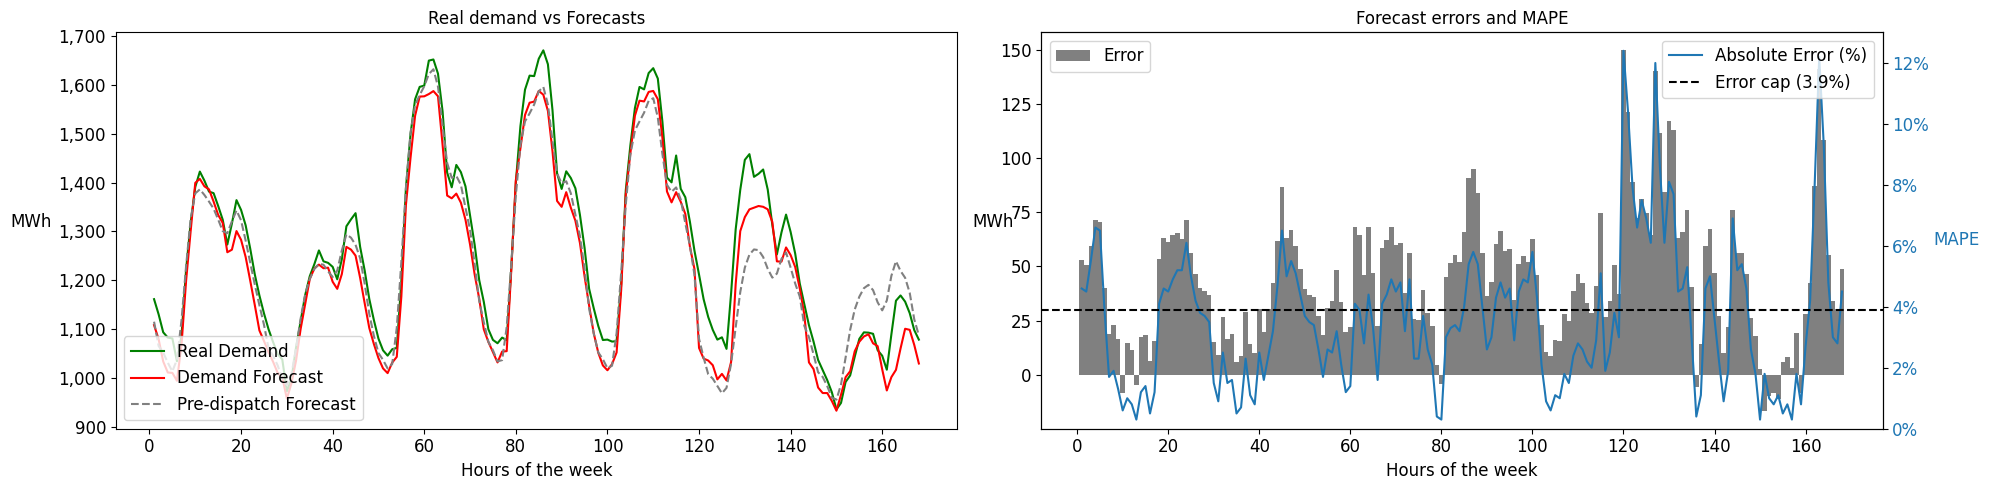

CPU times: total: 1.91 s
Wall time: 579 ms


In [ ]:
%%time
y_pred_train = generic_model.predict(X_train)
y_pred_test = generic_model.predict(X_test)

MAPE2improve = mean_absolute_percentage_error(y_test, y_pre_disp)
RMSE2improve = round(np.sqrt(mean_squared_error(y_test, y_pre_disp)),2)
RMSE_train_score = round(np.sqrt(mean_squared_error(y_train, y_pred_train)),2)
RMSE_test_score  = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),2)
MAPE_train_score = round(mean_absolute_percentage_error(y_train, y_pred_train),2)
MAPE_test_score  = round(mean_absolute_percentage_error(y_test, y_pred_test),2)


print('Test  RMSE:', RMSE_test_score, 'MWh')
print('Test  MAPE:', MAPE_test_score, '%')
print('')

plot_test_forecast(y_test, y_pred_test, y_pre_disp)

Lastly, take a look at the imported Optuna study to see the optimization progress and the hyperparameters impact. <br>
Notice that the objective value is **-RMSE**, and the optimization is trying to maximize this value, as defined in *model_hyperparameter_search* function.

SHAP Summary Plot (Global Feature Importance)


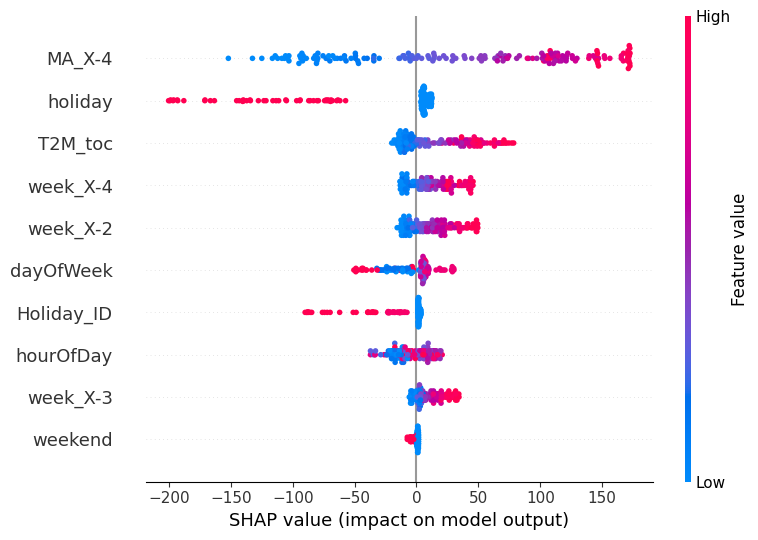

SHAP Force Plot (Local Explanation for First Test Instance)


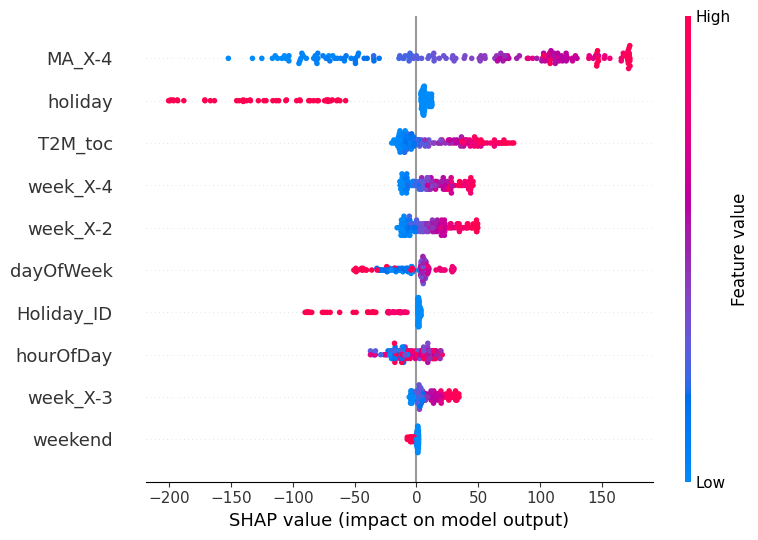

In [ ]:
# ---------------------- Explainability with SHAP ----------------------

import shap
explainer = shap.TreeExplainer(generic_model)
shap_values = explainer.shap_values(X_test)

print("SHAP Summary Plot (Global Feature Importance)")
shap.summary_plot(shap_values, X_test)

import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('global_shap_summary.png')
print("SHAP Force Plot (Local Explanation for First Test Instance)")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


In [ ]:
shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values(by='mean_abs_shap', ascending=False)
top_features = shap_importance_df['feature'].head(20).tolist() 
print(top_features)


['MA_X-4', 'holiday', 'T2M_toc', 'week_X-4', 'week_X-2', 'dayOfWeek', 'Holiday_ID', 'hourOfDay', 'week_X-3', 'weekend']


In [23]:
X_train_selected = X_train[top_features].copy()
X_test_selected = X_test[top_features].copy()


In [ ]:
reg_selected = XGBRegressor(**generic_model_study.best_params)
reg_selected.fit(X_train_selected, y_train)

y_pred_selected_test = reg_selected.predict(X_test_selected)


MAPE_selected = mean_absolute_percentage_error(y_test, y_pred_selected_test)
RMSE_selected = round(np.sqrt(mean_squared_error(y_test, y_pred_selected_test)), 2)

print("Selected Feature Model — Test RMSE:", RMSE_selected, "MWh")
print("Selected Feature Model — Test MAPE:", MAPE_selected, "%")


Selected Feature Model — Test RMSE: 54.15 MWh
Selected Feature Model — Test MAPE: 3.61 %


In [25]:
print("Original MAPE:", MAPE_test_score, "%")
print("Selected Feature MAPE:", MAPE_selected, "%")
print("Original RMSE:", RMSE_test_score, "MWh")
print("Selected Feature RMSE:", RMSE_selected, "MWh")


Original MAPE: 3.56 %
Selected Feature MAPE: 3.61 %
Original RMSE: 53.27 MWh
Selected Feature RMSE: 54.15 MWh


In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import shap
explainer = shap.TreeExplainer(generic_model)

shap_values = explainer.shap_values(X_test)
shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values(by='mean_abs_shap', ascending=False)
threshold = 0.01
top_features = shap_importance_df[shap_importance_df['mean_abs_shap'] > threshold]['feature'].tolist()
low_impact_features = shap_importance_df[shap_importance_df['mean_abs_shap'] <= threshold]['feature'].tolist()
X_train_top = X_train[top_features].copy()
X_test_top = X_test[top_features].copy()
X_train_low = X_train[low_impact_features].copy()
X_test_low = X_test[low_impact_features].copy()
X_train_agg = pd.DataFrame({
    'agg_low_features_sum': X_train_low.sum(axis=1),
    'agg_low_features_mean': X_train_low.mean(axis=1)
})
X_test_agg = pd.DataFrame({
    'agg_low_features_sum': X_test_low.sum(axis=1),
    'agg_low_features_mean': X_test_low.mean(axis=1)
})


X_train_final = pd.concat([X_train_top, X_train_agg], axis=1)
X_test_final = pd.concat([X_test_top, X_test_agg], axis=1)

reg_selected = XGBRegressor(**generic_model_study.best_params)
reg_selected.fit(X_train_final, y_train)
y_pred_selected_test = reg_selected.predict(X_test_final)

MAPE_selected = mean_absolute_percentage_error(y_test, y_pred_selected_test)
RMSE_selected = round(np.sqrt(mean_squared_error(y_test, y_pred_selected_test)), 2)

print("Selected Feature Model — Test RMSE:", RMSE_selected, "MWh")
print("Selected Feature Model — Test MAPE:", MAPE_selected, "%")


Selected Feature Model — Test RMSE: 54.3 MWh
Selected Feature Model — Test MAPE: 0.03632016391096661 %


In [30]:
print("Low impact features:", low_impact_features)
print("Number of low impact features:", len(low_impact_features))


Low impact features: []
Number of low impact features: 0


In [ ]:

import seaborn as sns

if len(low_impact_features) > 1:
    corr_matrix = X_train[low_impact_features].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Low-Impact Features')
    plt.show()
else:
    print("Not enough low-impact features to compute correlations.")


Not enough low-impact features to compute correlations.


In [ ]:
shap_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': shap_abs_mean
})
total_shap = shap_importance_df['mean_abs_shap'].sum()
shap_importance_df['percent_impact'] = (shap_importance_df['mean_abs_shap'] / total_shap) * 100
shap_importance_df = shap_importance_df.sort_values(by='percent_impact', ascending=False)
print(shap_importance_df)


      feature  mean_abs_shap  percent_impact
3      MA_X-4      88.232124       37.125027
6     holiday      40.543125       17.059145
9     T2M_toc      23.947556       10.076303
2    week_X-4      17.045616        7.172206
0    week_X-2      16.896538        7.109479
4   dayOfWeek      13.323969        5.606266
7  Holiday_ID      12.842384        5.403632
8   hourOfDay      12.595347        5.299686
1    week_X-3      10.670166        4.489637
5     weekend       1.565267        0.658610


In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import shap
explainer = shap.TreeExplainer(generic_model)
shap_values = explainer.shap_values(X_test)
shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values(by='mean_abs_shap', ascending=False)
total_shap = shap_importance_df['mean_abs_shap'].sum()
shap_importance_df['percent_impact'] = (shap_importance_df['mean_abs_shap'] / total_shap) * 100

print("Feature impact summary:\n", shap_importance_df)
threshold_percent = 1.0
top_features = shap_importance_df[shap_importance_df['percent_impact'] > threshold_percent]['feature'].tolist()
low_impact_features = shap_importance_df[shap_importance_df['percent_impact'] <= threshold_percent]['feature'].tolist()

print(f"Top features ({len(top_features)}): {top_features}")
print(f"Low impact features ({len(low_impact_features)}): {low_impact_features}")

X_train_top = X_train[top_features].copy()
X_test_top = X_test[top_features].copy()

if len(low_impact_features) > 0:
    
    X_train_low_agg = X_train[low_impact_features].sum(axis=1).rename('agg_low_features_sum')
    X_test_low_agg = X_test[low_impact_features].sum(axis=1).rename('agg_low_features_sum')
    X_train_final = pd.concat([X_train_top, X_train_low_agg], axis=1)
    X_test_final = pd.concat([X_test_top, X_test_low_agg], axis=1)
else:
    
    X_train_final = X_train_top
    X_test_final = X_test_top
reg_selected = XGBRegressor(**generic_model_study.best_params)
reg_selected.fit(X_train_final, y_train)
y_pred_selected_test = reg_selected.predict(X_test_final)
MAPE_selected = mean_absolute_percentage_error(y_test, y_pred_selected_test)
RMSE_selected = round(np.sqrt(mean_squared_error(y_test, y_pred_selected_test)), 2)

print("Selected Feature Model — Test RMSE:", RMSE_selected, "MWh")
print("Selected Feature Model — Test MAPE:", MAPE_selected * 100, "%")  # multiplied by 100 for %



Feature impact summary:
       feature  mean_abs_shap  percent_impact
3      MA_X-4      88.232124       37.125031
6     holiday      40.543125       17.059147
9     T2M_toc      23.947556       10.076304
2    week_X-4      17.045616        7.172207
0    week_X-2      16.896538        7.109479
4   dayOfWeek      13.323969        5.606266
7  Holiday_ID      12.842384        5.403632
8   hourOfDay      12.595347        5.299687
1    week_X-3      10.670166        4.489637
5     weekend       1.565267        0.658610
Top features (9): ['MA_X-4', 'holiday', 'T2M_toc', 'week_X-4', 'week_X-2', 'dayOfWeek', 'Holiday_ID', 'hourOfDay', 'week_X-3']
Low impact features (1): ['weekend']
Selected Feature Model — Test RMSE: 54.15 MWh
Selected Feature Model — Test MAPE: 3.608573881964234 %


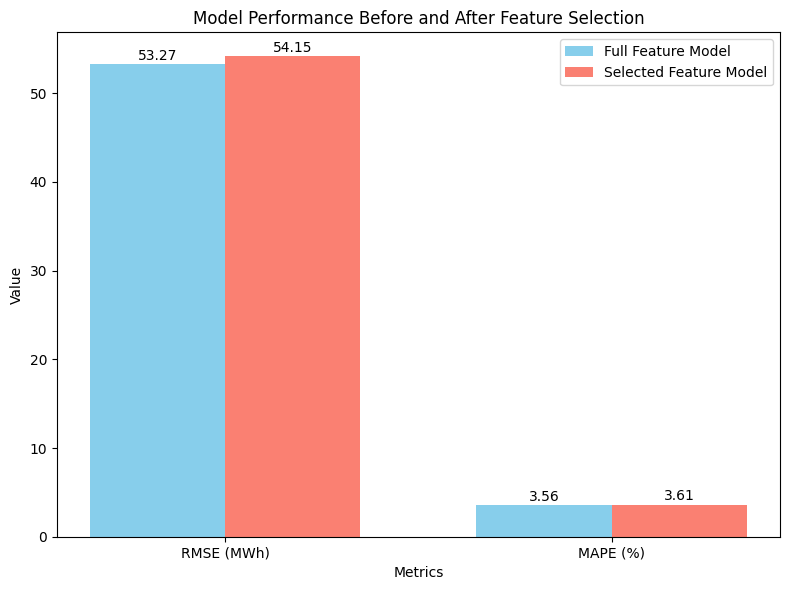

In [ ]:
metrics = ['RMSE (MWh)', 'MAPE (%)']
original = [53.27, 3.56]
selected = [54.15, 3.61]
bar_width = 0.35
x = range(len(metrics))
plt.figure(figsize=(8, 6))
plt.bar(x, original, width=bar_width, label='Full Feature Model', color='skyblue')
plt.bar([i + bar_width for i in x], selected, width=bar_width, label='Selected Feature Model', color='salmon')
for i in range(len(metrics)):
    plt.text(i, original[i] + 0.5, f'{original[i]}', ha='center')
    plt.text(i + bar_width, selected[i] + 0.5, f'{selected[i]}', ha='center')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Before and After Feature Selection')
plt.xticks([i + bar_width / 2 for i in x], metrics)
plt.legend()
plt.tight_layout()

plt.savefig('comparison_metrics.png', dpi=300)
plt.show()
